# Comparative Analysis of Structured vs Baseline LDA

This notebook loads `processed_data.csv` and performs topic modeling on two text inputs:
- **Structured approach:** Using the LLM-based structured text (column `structured_text`)
- **Baseline approach:** Using the preprocessed raw text (column `processed_text`)

We will train LDA models for each approach and evaluate them using:
- **Topic Coherence:** via Gensim’s CoherenceModel (e.g. using the `c_v` metric)
- **Topic Diversity:** computed as the ratio of unique words in top topics vs. total words
- **Perplexity:** based on the LDA model’s log perplexity on the corpus

We then generate interactive pyLDAvis visualizations, topic word clouds, analyze document–topic distributions,
and compare the metrics across both approaches.


## 1. Setup and Data Loading


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Download stopwords if needed
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Load the processed data
df = pd.read_csv("../results/parallel/final_processed_data.csv")
print("Data shape:", df.shape)
# Take a look at the first few rows
df.head()



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sammucyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data shape: (10380, 11)


,themes,emotional_tone,concerns,cognitive_patterns,social_context,original_text,id,structured_text,structured_tokens,processed_text,baseline_tokens
0,"['Mental health struggles', 'Personal growth',...",positive,"['Long-term depression', 'Suicidal thoughts', ...","['All-or-nothing thinking', 'Overgeneralizatio...","['Family background', 'Support from friends', ...",Overcoming a Mental Illness is Like Trying to ...,3,"THEMES: Mental health struggles, Personal grow...","['THEMES', 'mental', 'health', 'struggle', 'pe...",overcoming a mental illness is like trying to ...,"['overcome', 'mental', 'illness', 'try', 'lose..."
1,"['mental health', 'depression', 'anxiety', 'me...",negative,"['continuous low mood', 'feeling hopeless', 'l...","['catastrophizing', 'all-or-nothing thinking',...","['recent breakup', 'relationships with females...",Doctor has out me on citalopram. So on the 10t...,27,"THEMES: mental health, depression, anxiety, me...","['THEMES', 'mental', 'health', 'depression', '...",doctor has out me on citalopram so on the th o...,"['doctor', 'citalopram', 'december', 'doctor',..."
2,"['mental health struggles', 'depression', 'sel...",negative,"['feelings of loneliness', 'lack of motivation...","['catastrophizing', 'all-or-nothing thinking',...","['relationship with girlfriend', 'relationship...",Am I the only one who feels this way? Hello ev...,36,"THEMES: mental health struggles, depression, s...","['THEMES', 'mental', 'health', 'struggle', 'de...",am i the only one who feels this way hello eve...,"['one', 'way', 'hello', 'everyone', 'want', 's..."
3,"['anxiety', 'depression', 'physical pain', 'mu...",negative,"['physical pain linked to emotional distress',...","['catastrophizing', 'negative self-talk']","['arguments with others', 'seeking advice from...",Physical pain with anxiety and depression When...,49,"THEMES: anxiety, depression, physical pain, mu...","['THEMES', 'anxiety', 'depression', 'physical'...",physical pain with anxiety and depression when...,"['physical', 'pain', 'anxiety', 'depression', ..."
4,"['self-harm', 'mental health hospitalization',...",negative,"['self-mutilation', 'suicidal thoughts', 'lack...","['impulsivity', 'risky behavior', 'negative se...","['roommate intervention', 'relationship with c...","Hello, I was emitted to a mental health hospit...",59,"THEMES: self-harm, mental health hospitalizati...","['THEMES', 'self', 'harm', 'mental', 'health',...",hello i was emitted to a mental health hospita...,"['hello', 'emit', 'mental', 'health', 'hospita..."


## 2. Preprocessing and Tokenization

We define a simple tokenizer function. Here, we remove punctuation, numbers, and stop words.
You may refine this preprocessing as required.

In [2]:
# Load spaCy for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Add domain-specific stopwords
mental_health_stopwords = {
    'feel', 'feeling', 'felt', 'just', 'like', 'know',
    'think', 'get', 'got', 'really', 'health', 'mental'}
STOPWORDS.update(mental_health_stopwords)

category_markers = [
    'THEMES:', 'EMOTION:', 'COGNITIVE:', 'CONCERNS:', 
    'KEYWORDS:', 'SOCIAL CONTEXT:']

def clean_and_tokenize(text):
    # Remove category markers
    for marker in category_markers:
        text = re.sub(marker, '', text, flags=re.IGNORECASE)

    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    # Lemmatize using spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_.lower() not in STOPWORDS 
              and token.is_alpha and len(token.lemma_) > 2]

    return tokens

# Create new columns with tokenized data for each approach
# For structured LDA, we use the 'structured_text'
df['structured_tokens'] = df['structured_text'].apply(lambda x: clean_and_tokenize(x))
# For baseline LDA, we use the 'processed_text'
df['baseline_tokens'] = df['processed_text'].apply(lambda x: clean_and_tokenize(x))

# Preview tokens
print("Structured tokens sample:", df['structured_tokens'].iloc[0])
print("Baseline tokens sample:", df['baseline_tokens'].iloc[0])


Structured tokens sample: ['struggle', 'personal', 'growth', 'cope', 'strategy', 'comparison', 'physical', 'relapse', 'recovery', 'positive', 'allornothing', 'thinking', 'overgeneralization', 'experience', 'comparative', 'thinking', 'could', 'socialcontext', 'aan', 'longterm', 'depression', 'suicidal', 'thought', 'ineffective', 'treatment', 'struggle', 'selfcare', 'relapse', 'ongoing', 'emotional', 'pain', 'family', 'background', 'support', 'friend', 'therapy', 'experience', 'engagement', 'community', 'activity', 'personal', 'achievement', 'fitness']
Baseline tokens sample: ['overcome', 'illness', 'try', 'lose', 'weight', 'hello', 'bed', 'idea', 'want', 'share', 'guy', 'struggle', 'depression', 'well', 'part', 'life', 'time', 'could', 'walk', 'speak', 'properly', 'verge', 'suicide', 'different', 'therapist', 'take', 'many', 'dose', 'antidepressant', 'none', 'work', 'could', 'bring', 'shower', 'change', 'brush', 'tooth', 'pretty', 'bad', 'could', 'recently', 'much', 'well', 'grateful', 

In [3]:
# example processed text
df['structured_tokens'].iloc[0]

['struggle',
 'personal',
 'growth',
 'cope',
 'strategy',
 'comparison',
 'physical',
 'relapse',
 'recovery',
 'positive',
 'allornothing',
 'thinking',
 'overgeneralization',
 'experience',
 'comparative',
 'thinking',
 'could',
 'socialcontext',
 'aan',
 'longterm',
 'depression',
 'suicidal',
 'thought',
 'ineffective',
 'treatment',
 'struggle',
 'selfcare',
 'relapse',
 'ongoing',
 'emotional',
 'pain',
 'family',
 'background',
 'support',
 'friend',
 'therapy',
 'experience',
 'engagement',
 'community',
 'activity',
 'personal',
 'achievement',
 'fitness']

## 3. Create Dictionary and Corpus for Each Approach

We build a Gensim dictionary and corpus for both the structured and baseline datasets.

In [4]:

# Structured approach
structured_tokens = df['structured_tokens'].tolist()
structured_dictionary = corpora.Dictionary(structured_tokens)
structured_corpus = [structured_dictionary.doc2bow(text) for text in structured_tokens]

# Baseline approach
baseline_tokens = df['baseline_tokens'].tolist()
baseline_dictionary = corpora.Dictionary(baseline_tokens)
baseline_corpus = [baseline_dictionary.doc2bow(text) for text in baseline_tokens]

print("Structured dictionary size:", len(structured_dictionary))
print("Baseline dictionary size:", len(baseline_dictionary))


Structured dictionary size: 7372
Baseline dictionary size: 24821




## 4. Train LDA Models

We train two LDA models (using Gensim's LdaModel) on each corpus. Adjust the parameters as needed.



In [5]:
num_topics = 10 
passes = 20

# Train LDA on structured data
lda_structured = models.LdaModel(corpus=structured_corpus,
                                 id2word=structured_dictionary,
                                 num_topics=num_topics,
                                 passes=passes,
                                 random_state=140)

# Train LDA on baseline data
lda_baseline = models.LdaModel(corpus=baseline_corpus,
                               id2word=baseline_dictionary,
                               num_topics=num_topics,
                               passes=passes,
                               random_state=140)

print("Structured LDA topics:")
for idx, topic in lda_structured.print_topics(-1):
    print("Topic {}: {}".format(idx, topic))
    
print("\nBaseline LDA topics:")
for idx, topic in lda_baseline.print_topics(-1):
    print("Topic {}: {}".format(idx, topic))




Structured LDA topics:
Topic 0: 0.055*"relationship" + 0.045*"negative" + 0.043*"family" + 0.033*"lack" + 0.032*"support" + 0.027*"friend" + 0.024*"struggle" + 0.023*"isolation" + 0.020*"catastrophizing" + 0.020*"thinking"
Topic 1: 0.094*"anger" + 0.039*"management" + 0.027*"pet" + 0.024*"frustration" + 0.020*"research" + 0.017*"violent" + 0.013*"game" + 0.011*"participation" + 0.011*"neutral" + 0.011*"teenage"
Topic 2: 0.097*"social" + 0.044*"anxiety" + 0.039*"negative" + 0.037*"interaction" + 0.033*"fear" + 0.018*"difficulty" + 0.018*"friend" + 0.013*"peer" + 0.013*"comparison" + 0.012*"judgment"
Topic 3: 0.199*"unknown" + 0.192*"analysis" + 0.189*"error" + 0.054*"mood" + 0.018*"swing" + 0.016*"fluctuation" + 0.007*"distancing" + 0.006*"pandemic" + 0.006*"graduation" + 0.005*"lie"
Topic 4: 0.027*"negative" + 0.027*"stress" + 0.023*"work" + 0.021*"job" + 0.020*"anxiety" + 0.020*"academic" + 0.019*"motivation" + 0.018*"impact" + 0.017*"environment" + 0.017*"life"
Topic 5: 0.078*"suppor


## 5. Evaluation Metrics

We calculate the following:
- **Coherence:** using the c_v metric
- **Perplexity:** via the log_perplexity function
- **Topic Diversity:** computed as the ratio of unique top words from all topics

In [22]:
# Calculate coherence scores for both models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate topic diversity
def calculate_topic_diversity(model, dictionary, top_n=20):
    """
    Calculate topic diversity as the ratio of unique words in top-N words across all topics
    to the total number of words (top-N * num_topics)
    """
    topics = [dict(model.show_topic(topicid, topn=top_n)) for topicid in range(model.num_topics)]
    
    # Get all words from all topics
    words_across_topics = [word for topic in topics for word, _ in topic.items()]
    
    # Count unique words
    unique_words = set(words_across_topics)
    
    # Calculate diversity
    diversity = len(unique_words) / (model.num_topics * top_n)
    return diversity

# Calculate metrics for both models
metrics = {
    'Approach': ['Structured LDA', 'Baseline LDA'],
    'Coherence': [0, 0],
    'Diversity': [0, 0],
    'Perplexity': [0, 0]
}

# Calculate coherence for structured model
coherence_model_structured = CoherenceModel(
    model=lda_structured, 
    texts=structured_tokens,
    dictionary=structured_dictionary, 
    coherence='c_v'
)
metrics['Coherence'][0] = coherence_model_structured.get_coherence()

# Calculate coherence for baseline model
coherence_model_baseline = CoherenceModel(
    model=lda_baseline, 
    texts=baseline_tokens,
    dictionary=baseline_dictionary, 
    coherence='c_v'
)
metrics['Coherence'][1] = coherence_model_baseline.get_coherence()

# Calculate diversity
metrics['Diversity'][0] = calculate_topic_diversity(lda_structured, structured_dictionary)
metrics['Diversity'][1] = calculate_topic_diversity(lda_baseline, baseline_dictionary)

# Calculate perplexity (lower is better)
metrics['Perplexity'][0] = np.exp2(-lda_structured.log_perplexity(structured_corpus))
metrics['Perplexity'][1] = np.exp2(-lda_baseline.log_perplexity(baseline_corpus))

# Calculate percentage differences (structured vs baseline)
pct_diff = {
    'Coherence': (metrics['Coherence'][0] - metrics['Coherence'][1]) / metrics['Coherence'][1] * 100,
    'Diversity': (metrics['Diversity'][0] - metrics['Diversity'][1]) / metrics['Diversity'][1] * 100,
    'Perplexity': (metrics['Perplexity'][1] - metrics['Perplexity'][0]) / metrics['Perplexity'][0] * 100  # Inverted for perplexity (lower is better)
}

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("\nPercentage Differences (Structured vs Baseline):")
for metric, value in pct_diff.items():
    print(f"{metric}: {value:+.2f}% {'improvement' if value > 0 else 'decrease'}")


         Approach  Coherence  Diversity  Perplexity
0  Structured LDA   0.478549       0.67   91.216739
1    Baseline LDA   0.382260       0.70  194.486253

Percentage Differences (Structured vs Baseline):
Coherence: +25.19% improvement
Diversity: -4.29% decrease
Perplexity: +113.21% improvement


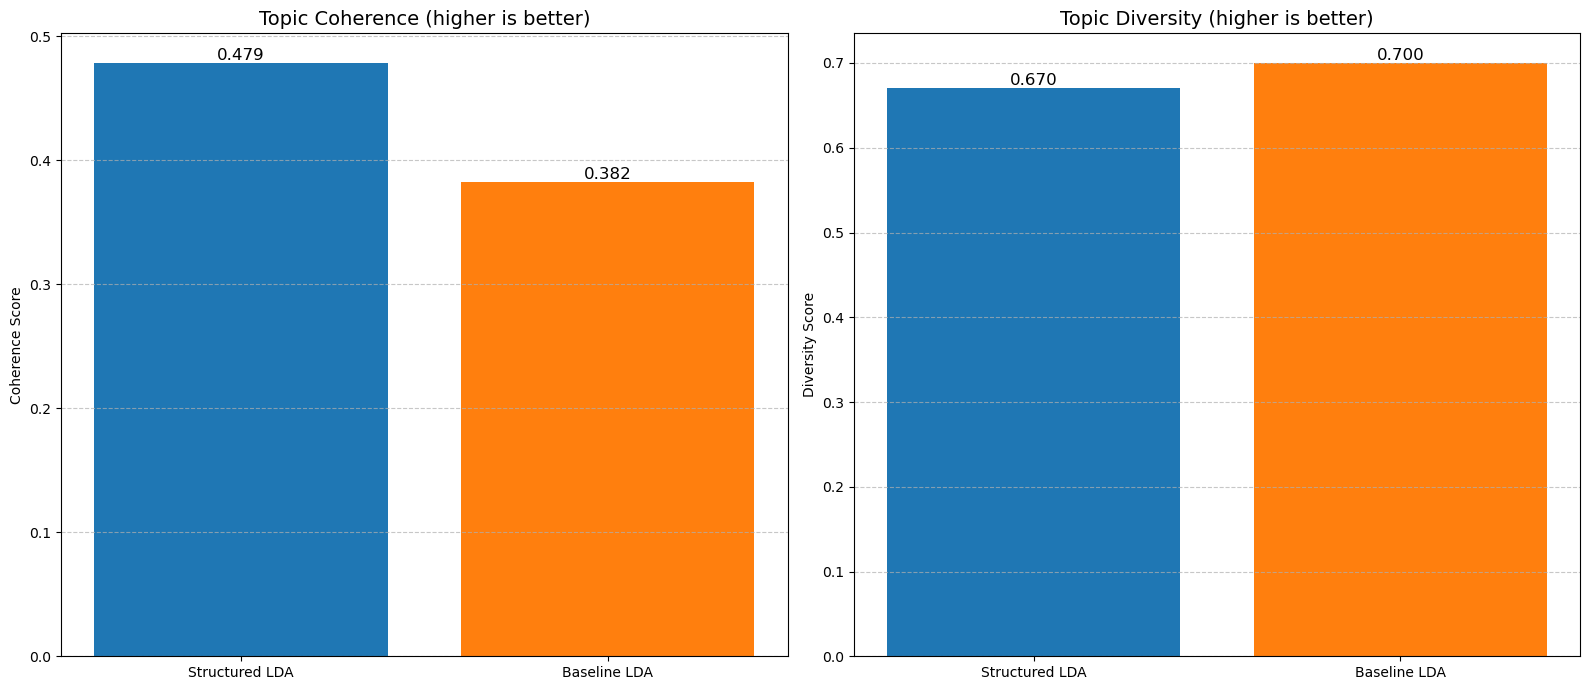

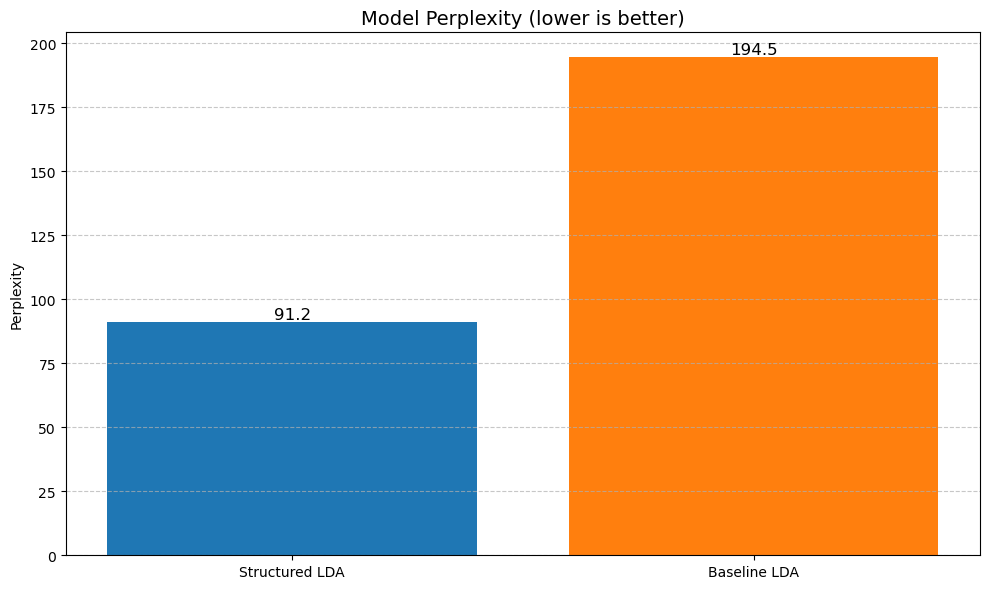

In [23]:
import matplotlib.pyplot as plt

# Coherence & Diversity side‑by‑side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, metric_name in [
    (axes[0], 'Coherence'),
    (axes[1], 'Diversity'),
]:
    bars = ax.bar(
        metrics['Approach'],
        metrics[metric_name],
        color=['#1f77b4', '#ff7f0e']
    )

    ax.set_title(f"Topic {metric_name} (higher is better)", fontsize=14)
    ax.set_ylabel(f"{metric_name} Score")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # optional value labels
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            f"{h:.3f}",
            ha='center', va='bottom', fontsize=12
        )

plt.tight_layout()
plt.show()

# Perplexity on its own
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    metrics['Approach'],
    metrics['Perplexity'],
    color=['#1f77b4', '#ff7f0e']
)

ax.set_title('Model Perplexity (lower is better)', fontsize=14)
ax.set_ylabel('Perplexity')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# optional value labels
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f"{h:.1f}",
        ha='center', va='bottom', fontsize=12
    )

plt.tight_layout()
plt.show()


### Observations:

- **Coherence (c_v)**  
  The structured approach scores a higher coherence compared to the baseline. This suggests that the topics generated using the structured text are more semantically related—i.e., the top words in each topic tend to co-occur in a meaningful way. 

- **Perplexity**  
  The structured model has a lower perplexity compared to the baseline model. Lower perplexity means the structured LDA model fits the data better and is better at predicting the distribution of words in the corpus. It indicates that the structured approach provides a more compact and reliable explanation of the data, which is beneficial when trying to relate these topics to underlying neural processes or clinical patterns.

- **Topic Diversity**  
  The baseline approach shows higher topic diversity compared to the structured approach. This metric reflects the ratio of unique words across the top words of all topics—so a higher diversity score means that the baseline topics cover a broader range of vocabulary. However, while the baseline may capture more variety, its lower coherence and higher perplexity suggest that the topics might be more diffuse or noisy. In contrast, the structured approach—although yielding less diverse topics—produces more focused, coherent themes that might better map onto specific patterns of neural activity or clinical conditions.



## 6. Interactive pyLDAvis Visualizations

We generate interactive visualizations for both models using pyLDAvis.


In [8]:
# For Structured LDA
vis_structured = gensimvis.prepare(lda_structured, structured_corpus, structured_dictionary)
pyLDAvis.display(vis_structured) 




In [9]:
# For Baseline LDA
vis_baseline = gensimvis.prepare(lda_baseline, baseline_corpus, baseline_dictionary)
pyLDAvis.display(vis_baseline)

## 7. Topic Word Clouds

For each model, we generate word clouds for each topic.



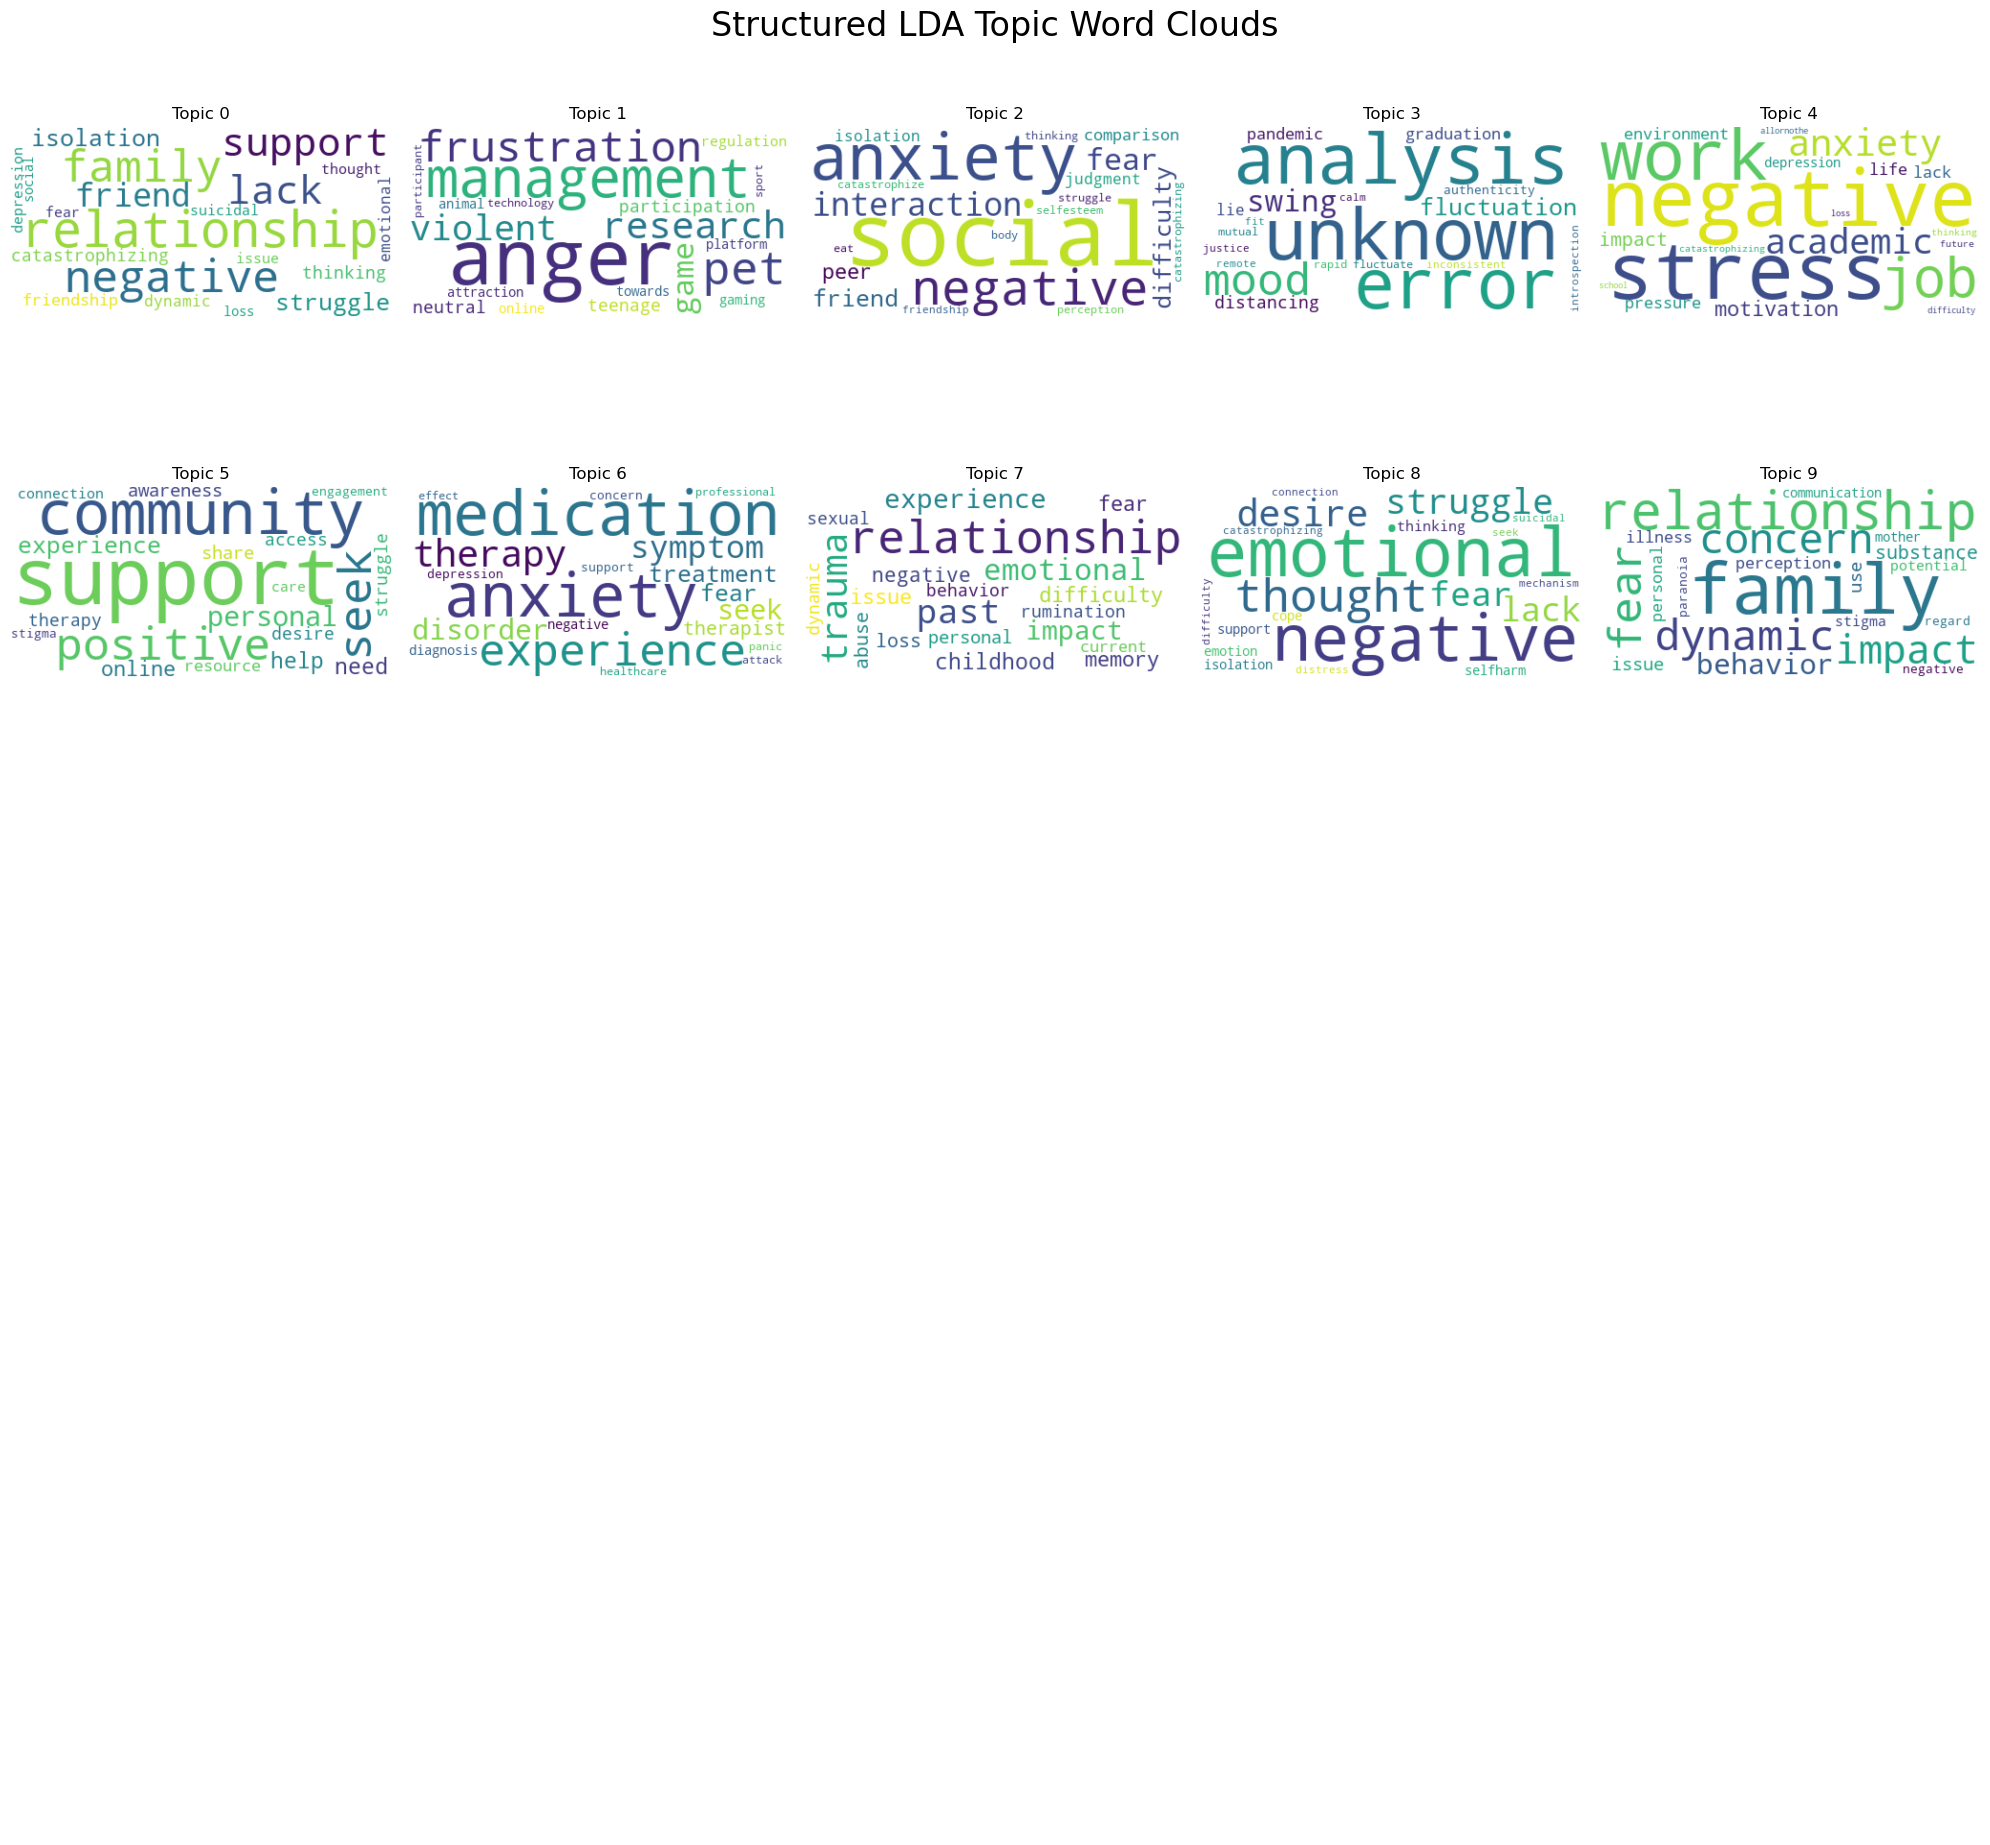

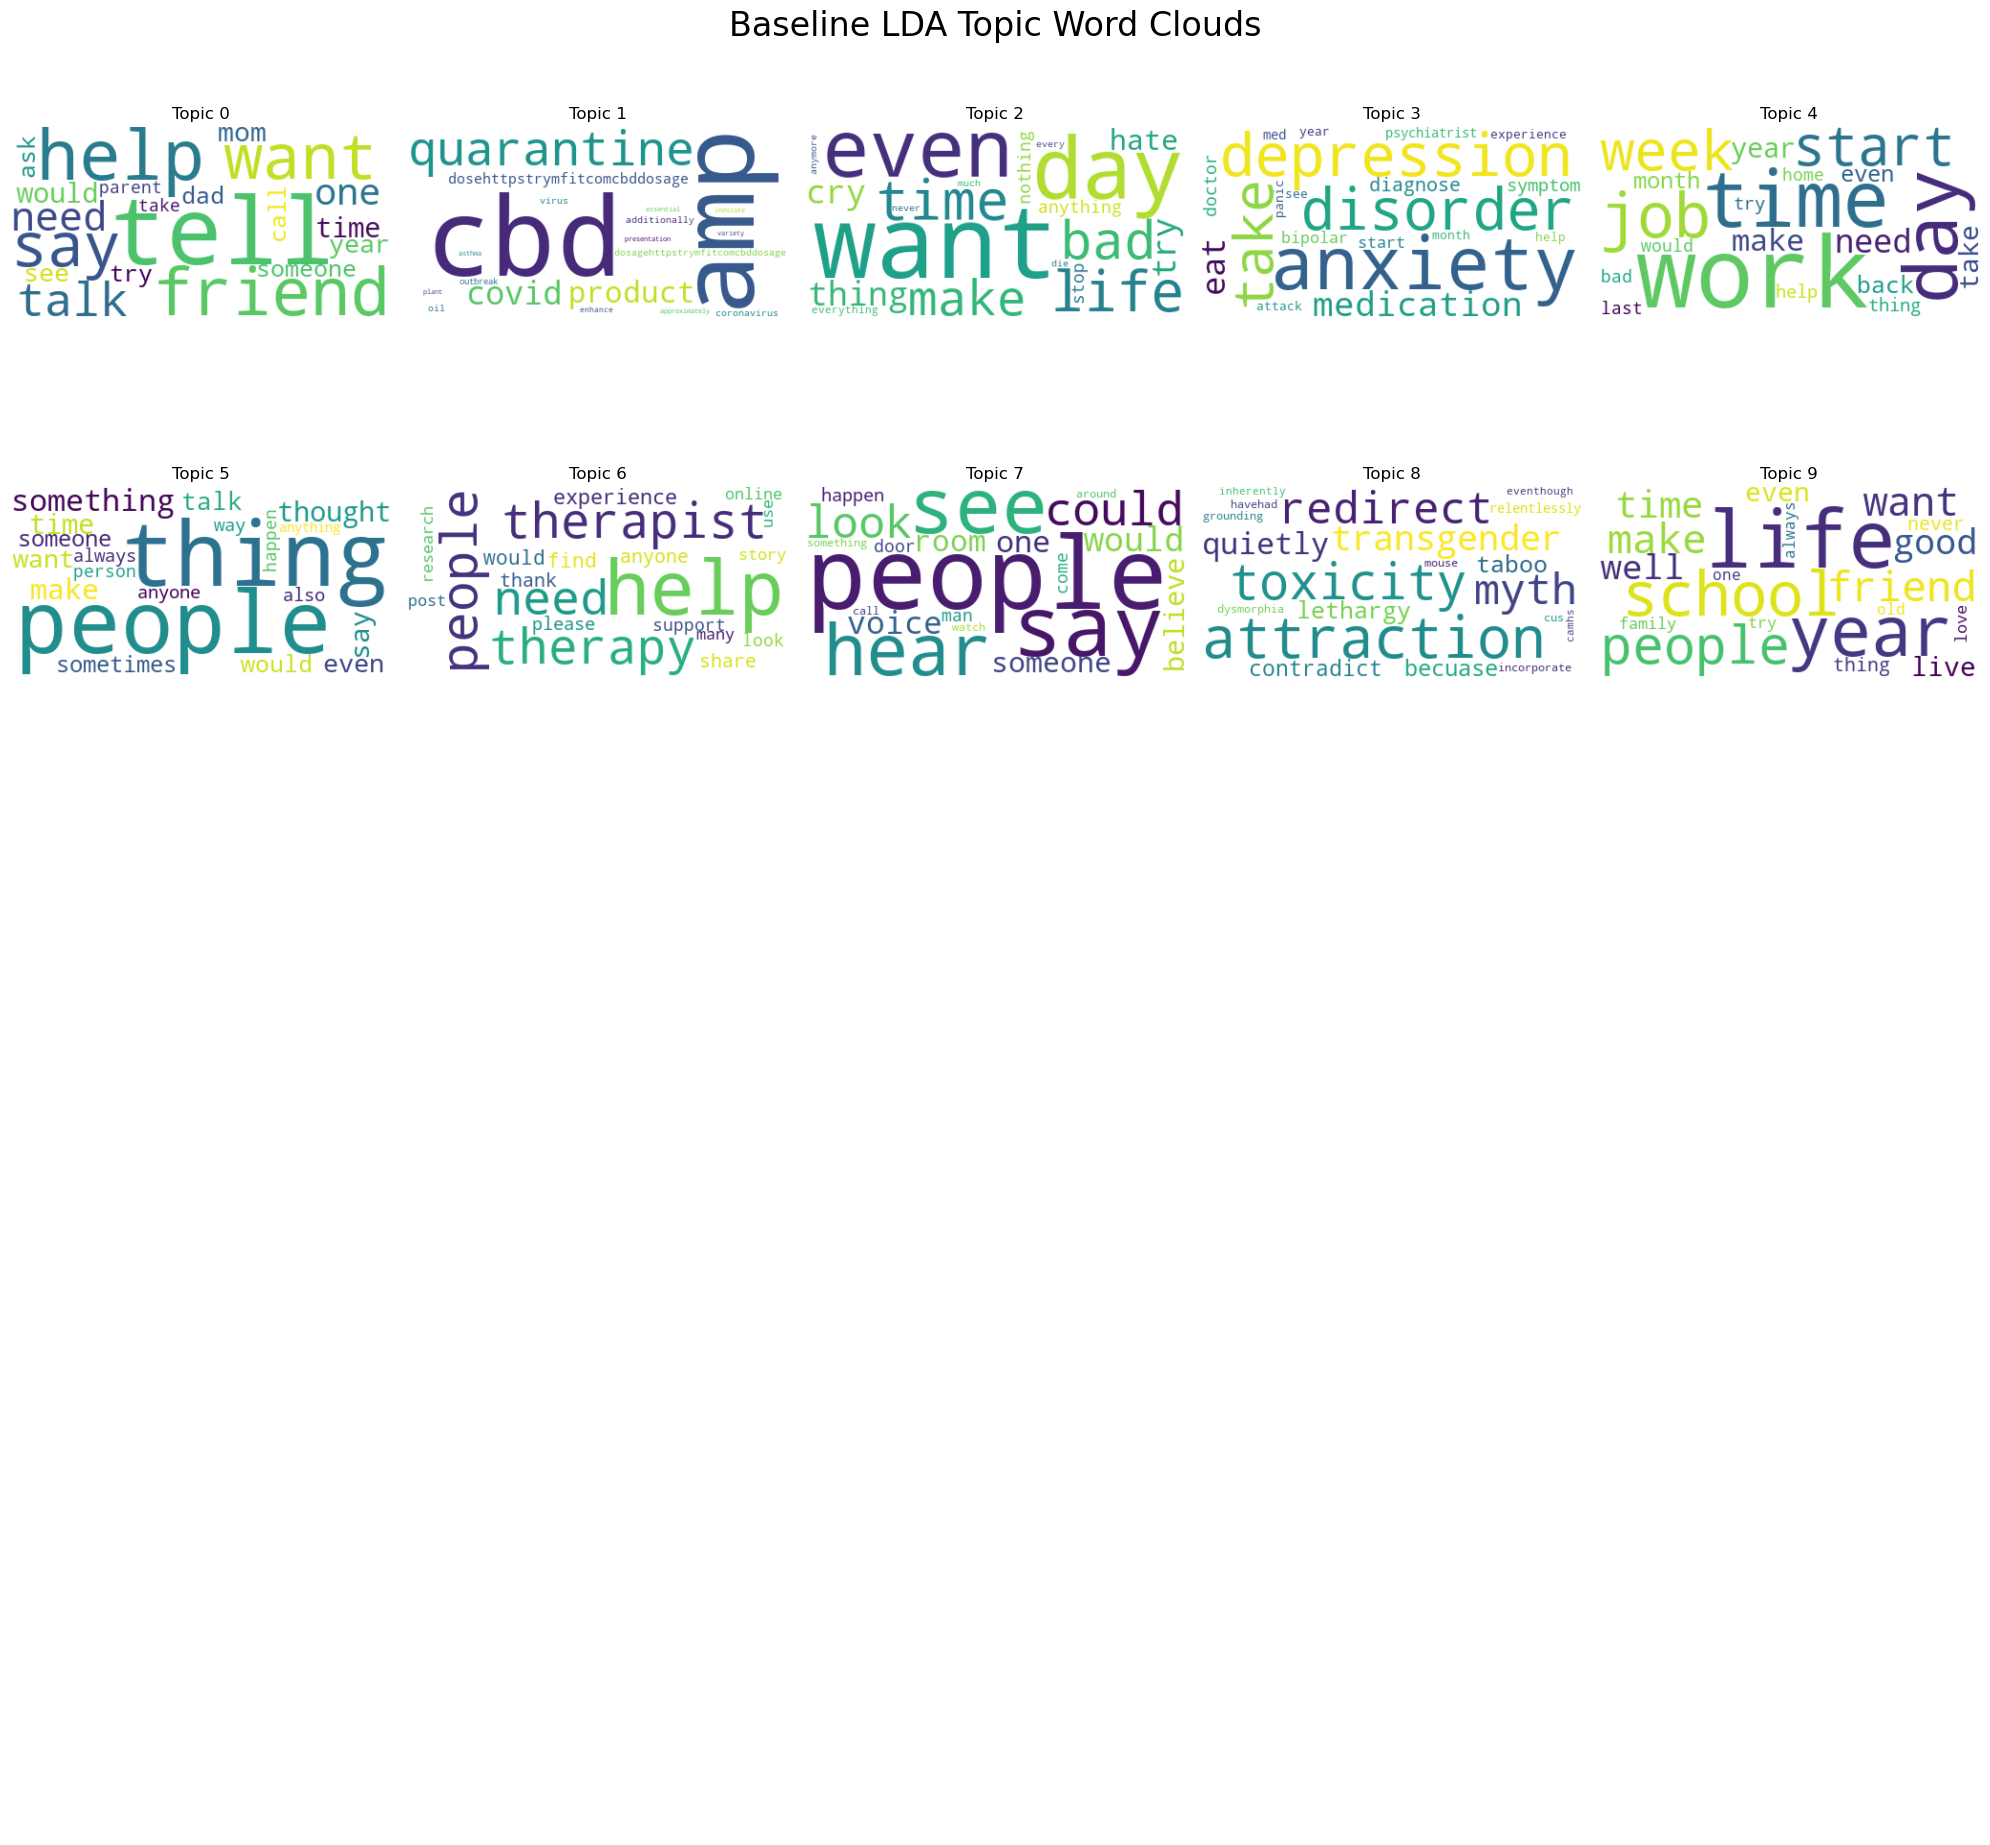

In [10]:
def plot_topic_wordclouds(lda_model, dictionary, num_topics=25, model_name=""):
    """
    Plot a grid of word clouds for topics in the LDA model
    """
    # Create a 5x5 grid of subplots
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.suptitle(f"{model_name} Topic Word Clouds", fontsize=24, y=0.92)
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot each topic's word cloud
    for i in range(min(num_topics, 25)):
        # Get the topic as a dictionary {word: weight}
        topic = lda_model.show_topic(i, topn=30)
        topic_words = dict(topic)
        
        # Generate word cloud
        wc = WordCloud(background_color='white', width=400, height=200, 
                       max_words=20, colormap='viridis')
        wordcloud_img = wc.generate_from_frequencies(topic_words)
        
        # Plot on the corresponding subplot
        axes[i].imshow(wordcloud_img, interpolation="bilinear")
        axes[i].set_title(f"Topic {i}", fontsize=12)
        axes[i].axis("off")
    
    # Hide any unused subplots
    for j in range(num_topics, 25):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Plot word clouds for structured model
plot_topic_wordclouds(lda_structured, structured_dictionary, 
                     num_topics=lda_structured.num_topics, 
                     model_name="Structured LDA")

# Plot word clouds for baseline model
plot_topic_wordclouds(lda_baseline, baseline_dictionary, 
                     num_topics=lda_baseline.num_topics, 
                     model_name="Baseline LDA")


### Observations

Structured LDA (First Image): The topics appear relatively distinct and interpretable. For example:
- Topic 0: Focuses on relationships, family, support, and negative feelings.
- Topic 1: Centers around anger, frustration, and management.
- Topic 2: Deals with social anxiety and interaction.
- Topic 4: Relates to stress, anxiety, work, and academics.
- Topic 6: Seems focused on medication, therapy, anxiety, and depression symptoms.
- Topic 9: Involves family dynamics, relationships, and concerns. 

The words within each topic seem thematically related, making it easier to understand the underlying theme the model has identified.

Baseline LDA (Second Image): The topics seem less distinct and potentially harder to interpret.
- Many topics feature very common words prominently (e.g., "want," "people," "say," "see," "make," "time," "help," "thing"). While these words might be frequent in the source text, their dominance across multiple topics can make the topics less specific.
- Some topics are clearer (e.g., Topic 3 relates to anxiety/depression/medication, Topic 1 mentions COVID/quarantine), but others are quite mixed (e.g., Topic 5, Topic 7).
  
The overlap of common words might indicate that the baseline model struggled to separate themes as effectively.

Conclusion:

  - The Structured (LLM-based) LDA appears to have produced more coherent, interpretable, and distinct topics compared to the Baseline LDA.
  - The themes identified by the Structured LDA seem more focused on specific aspects of mental health, relationships, and personal experiences.
  - The Baseline LDA results are noisier, with common words potentially obscuring the underlying thematic structure.
  - This suggests that whatever modifications were made to create the "Structured LDA" likely resulted in an improvement in topic quality for this particular dataset.

In essence, these results visually demonstrate the difference in output quality between a standard topic modeling approach (Baseline) and a potentially more refined one (Structured), with the structured approach yielding more meaningful results in this case.


## 8. Representative Documents for Each Topic

For each topic in our LDA model, this cell prints a few representative documents with two pieces of information:
- The processed/structured text (used for LDA modeling)
- The original post text (for verification)

This will allow us to verify that the extracted topic represents the content of the original text.


In [11]:
def print_representative_documents_with_original(lda_model, corpus, processed_col, original_col, num_examples=3):
    """
    For each topic, prints num_examples documents with high topic probability.
    It shows both the processed text (e.g., structured_text) used for LDA and the original post (original_text)
    for verification.
    
    Parameters:
    - lda_model: trained LDA model.
    - corpus: the Gensim corpus used by the LDA model.
    - processed_col: column name in df with the processed text used for modeling.
    - original_col: column name in df with the original post.
    - num_examples: number of example documents per topic.
    """
    # Compute document-topic distributions for each document 
    doc_topic_dist = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        topics = sorted(topics, key=lambda x: x[0])
        doc_topic_dist.append([prob for _, prob in topics])
    doc_topic_dist = np.array(doc_topic_dist)
    
    num_topics = lda_model.num_topics
    
    for topic in range(num_topics):
        print("=" * 80)
        print(f"Topic {topic}")
        # Get document indices sorted in descending order by topic probability
        sorted_indices = np.argsort(doc_topic_dist[:, topic])[::-1]
        
        for i in range(num_examples):
            idx = sorted_indices[i]
            prob = doc_topic_dist[idx, topic]
            print("-" * 40)
            print(f"Document Index: {idx} (Contribution of Topic {topic}: {prob:.3f})")
            print("\n**Processed Text (used in modeling):**")
            print(df[processed_col].iloc[idx])
            print("\n**Original Post:**")
            print(df[original_col].iloc[idx])
            print("-" * 40, "\n")
        print("\n")


print_representative_documents_with_original(
    lda_model=lda_structured, 
    corpus=structured_corpus, 
    processed_col='structured_text', 
    original_col='original_text', 
    num_examples=3
)


Topic 0
----------------------------------------
Document Index: 3117 (Contribution of Topic 0: 0.980)

**Processed Text (used in modeling):**
THEMES: mental health struggles, anxiety, relationship issues, family dynamics, friendship challenges, self-esteem, depression, support systems EMOTION: negative COGNITIVE: catastrophizing, negative self-talk, all-or-nothing thinking, fear of rejection, overgeneralization CONCERNS: struggles with anxiety, difficult family background, questionable relationship, feelings of depression, issues with friendships, fear of loneliness, low self-esteem, struggles in therapy KEYWORDS: family dynamics, romantic relationship, friendship struggles, sense of isolation

**Original Post:**

 Some background info: recent college grad with a horrible family background. Lots of fighting, animosity, parents holding money and their love/acceptance over my head. Usually having to do with who I'm dating. 

Current situation on that: dating a guy who is 15 years older 

In [27]:
import numpy as np
import pandas as pd

def save_representative_documents(lda_model, corpus, df, output_path, num_examples=3):
    # Compute full document–topic probability matrix
    doc_topic_dist = []
    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        topics = sorted(topics, key=lambda x: x[0])
        doc_topic_dist.append([prob for _, prob in topics])
    doc_topic_dist = np.array(doc_topic_dist)

    # Gather the top N examples per topic
    num_topics = lda_model.num_topics
    results = []
    for topic in range(num_topics):
        sorted_idxs = np.argsort(doc_topic_dist[:, topic])[::-1]
        for rank in range(num_examples):
            idx = sorted_idxs[rank]
            prob = doc_topic_dist[idx, topic]
            results.append({
                'topic': topic,
                'rank':  rank + 1,
                'doc_index':    idx,
                'probability':  prob,
                'processed_text': df.loc[idx, 'structured_text'],
                'original_text':  df.loc[idx, 'original_text']
            })

    out_df = pd.DataFrame(results)
    out_df.to_csv(output_path, index=False)
    print(f"✅ Saved top {num_examples} documents per topic to {output_path}")

In [28]:
save_representative_documents(
    lda_structured,
    structured_corpus,
    df,
    "../results/representative_documents_structured.csv"
)
save_representative_documents(
    lda_baseline,
    baseline_corpus,
    df,
    "../results/representative_documents_baseline.csv"  
)

✅ Saved top 3 documents per topic to ../results/representative_documents_structured.csv
✅ Saved top 3 documents per topic to ../results/representative_documents_baseline.csv


| Column              | Description                                                                                                              |
| ------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **topic**           | Integer ID of the topic (0 through *K − 1*), where K is the number of topics (K = 10).                                                  |
| **rank**            | Position within that topic’s top N list:                                                                                   |
|                     | • 1 = highest-probability document                                                                                         |
|                     | • 2 = second-highest                                                                                                       |
|                     | • 3 = third-highest, etc.                                                                                                  |
| **doc\_index**      | The original row index in dataset `df` (so we can cross-reference other metadata we might have stored).                     |
| **probability**     | The model’s estimated weight $p(topic \mid document)$ for that document—i.e. how strongly that doc “belongs” to the topic. |
| **processed\_text** | The cleaned/structured text that we actually fed into the LDA (e.g. tokenized, filtered, transformed).                    |
| **original\_text**  | The raw source text (e.g. the full post or article) for human verification and context.                                    |
